# EDA on the MIND Dataset

The dataset used in this project can be found on Kaggle: [MIND: Microsoft News Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/mind-news-dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
col_names = ["impression_id", "user_id", "time", "history", "impressions"]
behaviors = pd.read_csv("behaviors.tsv", sep="\t", names=col_names, quoting=3)

col_names = ["id", "category", "subcategory", "title", "abstract", "link", "title_entities", "abstract_entities"]
news = pd.read_csv("news.tsv", sep="\t", names=col_names, quoting=3)


def load_vec_file(path):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) <= 2:
                continue
            key = parts[0]
            vec = np.array(list(map(float, parts[1:])))
            embeddings[key] = vec
    return embeddings

entity_embeddings = load_vec_file("entity_embedding.vec")
relation_embeddings = load_vec_file("relation_embedding.vec")

In [3]:
len(news)

51282

Let's remove some of the news

In [4]:
# --- Step 1: Stratified sampling by category/subcategory ---
sample_size = 5000
news = news.groupby(['category', 'subcategory'], group_keys=False).apply(
    lambda x: x.sample(frac=sample_size/len(news), random_state=42)
)
news = news.reset_index(drop=True)
valid_news_ids = set(news['id'])

# --- Step 2: Filter histories and impressions ---
def filter_history(history_str, valid_ids):
    if pd.isna(history_str) or history_str == "":
        return ""
    return " ".join([nid for nid in history_str.split() if nid in valid_ids])

def filter_impressions(impressions_str, valid_ids):
    if pd.isna(impressions_str) or impressions_str == "":
        return ""
    return " ".join([pair for pair in impressions_str.split() if pair.split("-")[0] in valid_ids])

behaviors['history'] = behaviors['history'].apply(lambda x: filter_history(x, valid_news_ids))
behaviors['impressions'] = behaviors['impressions'].apply(lambda x: filter_impressions(x, valid_news_ids))

# --- Step 3: Remove behaviors with no impressions left ---
behaviors = behaviors[behaviors['impressions'] != ""]

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_99624/2998209742.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news = news.groupby(['category', 'subcategory'], group_keys=False).apply(


# News and behaviors

In [5]:
behaviors.head()

,impression_id,user_id,time,history,impressions
2,3,U73700,11/14/2019 7:01:48 AM,,N35389-0 N49712-0 N10960-0
4,5,U8125,11/12/2019 4:11:21 PM,,N39985-0 N33883-0 N46992-0 N20915-0 N57319-0
6,7,U8355,11/11/2019 12:22:09 PM,N157,N58572-0 N41774-0 N33964-0 N47229-0 N9271-0 N5...
8,9,U79199,11/13/2019 10:13:02 AM,N459 N27235,N51048-1
10,11,U89744,11/14/2019 8:38:04 AM,N55051 N12349 N61342 N10417 N25885 N10888,N52520-0 N49180-0 N49712-0 N18850-0 N10960-0 N...


In [6]:
news.head()

,id,category,subcategory,title,abstract,link,title_entities,abstract_entities
0,N14147,autos,autosbuying,2020 Hyundai Veloster N Discount Makes It A Be...,A little bit goes a long way.,https://assets.msn.com/labs/mind/BBWqnmL.html,"[{""Label"": ""Hyundai Veloster"", ""Type"": ""V"", ""W...",[]
1,N25035,autos,autosbuying,Why Does The Dealer Want Me To Agree To A Pric...,This week we are discussing shady test drive p...,https://assets.msn.com/labs/mind/AAJHCGG.html,[],[]
2,N1529,autos,autosbuying,How you can buy a discounted car through Costco,The Costco Auto Program allows Costco members ...,https://assets.msn.com/labs/mind/BBRGHYP.html,"[{""Label"": ""Costco"", ""Type"": ""O"", ""WikidataId""...","[{""Label"": ""Costco"", ""Type"": ""O"", ""WikidataId""..."
3,N59109,autos,autosclassics,Flamed 1957 Chevrolet 3100 Is A Work Of Art,Amazing attention to detail inside and out!,https://assets.msn.com/labs/mind/AAIPfCn.html,[],[]
4,N27213,autos,autosclassics,Rare 1978 Ford Bronco 4×4 ready for sale at Br...,Second-generation Bronco was originally owned ...,https://assets.msn.com/labs/mind/BBWtAqL.html,"[{""Label"": ""Ford Bronco"", ""Type"": ""V"", ""Wikida...","[{""Label"": ""Ford Bronco"", ""Type"": ""V"", ""Wikida..."


First let's remove missing values and unused columns

In [7]:
print(news.isnull().sum())
print("Total missing:", news.isnull().sum().sum())

id                     0
category               0
subcategory            0
title                  0
abstract             265
link                   0
title_entities         0
abstract_entities      0
dtype: int64
Total missing: 265


In [8]:
news = news.dropna(subset=['abstract'])

#columns_to_drop = ['category', 'subcategory', 'title_entities', 'abstract_entities']
#news = news.drop(columns=columns_to_drop, errors='ignore')

print(news.isnull().sum())
print("Total missing:", news.isnull().sum().sum())

id                   0
category             0
subcategory          0
title                0
abstract             0
link                 0
title_entities       0
abstract_entities    0
dtype: int64
Total missing: 0


In [9]:
print(behaviors.isnull().sum())
print("Total missing:", behaviors.isnull().sum().sum())

impression_id    0
user_id          0
time             0
history          0
impressions      0
dtype: int64
Total missing: 0


In [10]:
behaviors = behaviors.dropna(subset=['history'])
print(behaviors.isnull().sum())
print("Total missing:", behaviors.isnull().sum().sum())

impression_id    0
user_id          0
time             0
history          0
impressions      0
dtype: int64
Total missing: 0


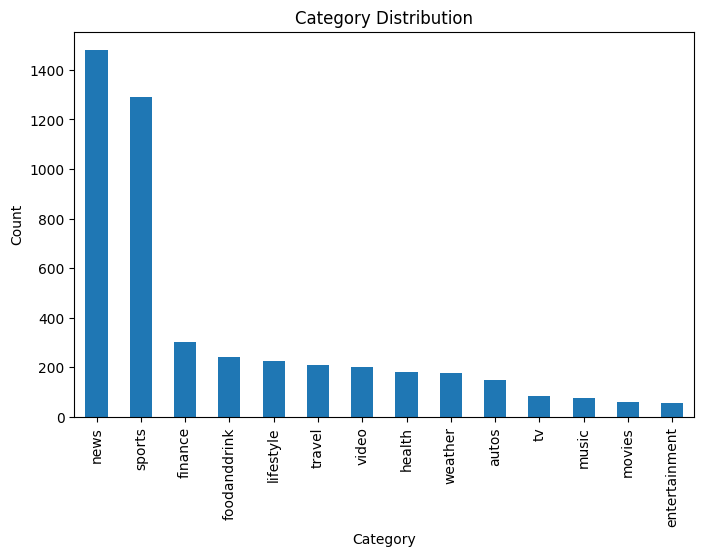

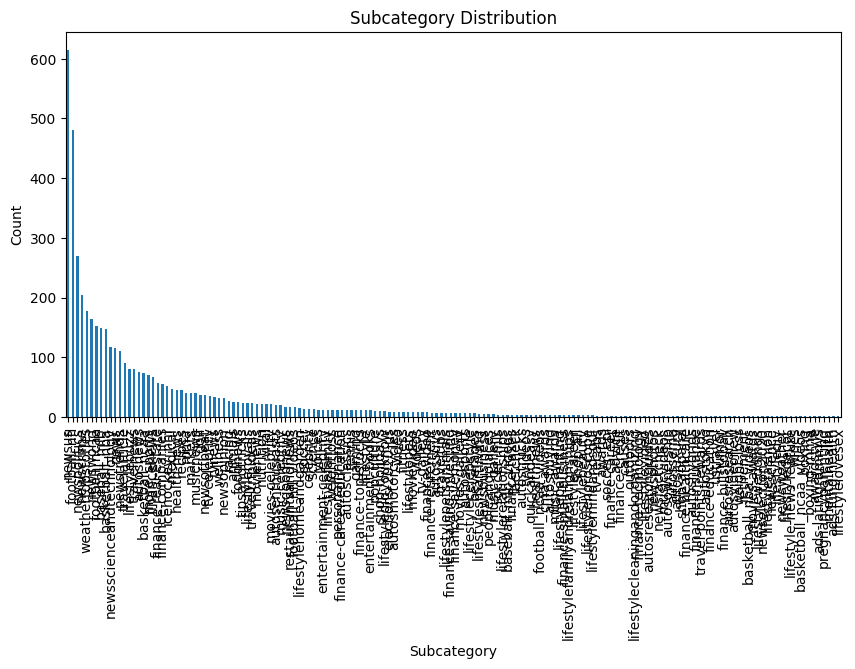

In [11]:
plt.figure(figsize=(8, 5))
news['category'].value_counts().plot(kind='bar')
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Plot subcategory distribution
plt.figure(figsize=(10, 5))
news['subcategory'].value_counts().plot(kind='bar')
plt.title("Subcategory Distribution")
plt.xlabel("Subcategory")
plt.ylabel("Count")
plt.show()

As we can see there is a huge imbalance over the category, therefore we will only be using the author and the abstract for our content based models.

In [12]:
behaviors['time'] = pd.to_datetime(behaviors['time'], format='%m/%d/%Y %I:%M:%S %p')

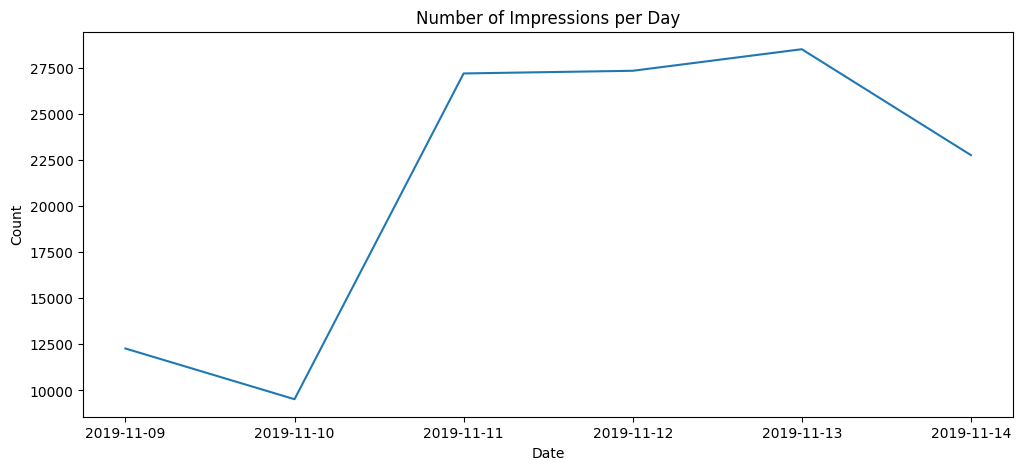

In [13]:
behaviors['date'] = behaviors['time'].dt.date
behaviors['hour'] = behaviors['time'].dt.hour
behaviors['day_of_week'] = behaviors['time'].dt.day_name()

# 1. Activity over time (by day)
daily_activity = behaviors.groupby('date').size()
plt.figure(figsize=(12,5))
daily_activity.plot()
plt.title('Number of Impressions per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_99624/4190394435.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_activity.index, y=hourly_activity.values, palette="viridis")


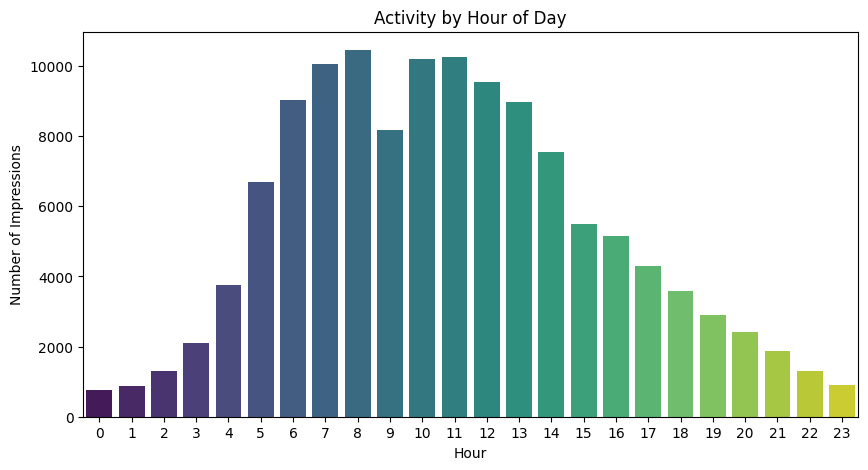

In [14]:
# 2. Activity by hour of day
hourly_activity = behaviors.groupby('hour').size()
plt.figure(figsize=(10,5))
sns.barplot(x=hourly_activity.index, y=hourly_activity.values, palette="viridis")
plt.title('Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Impressions')
plt.show()

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_99624/3826240028.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_activity.index, y=dow_activity.values, palette="magma")


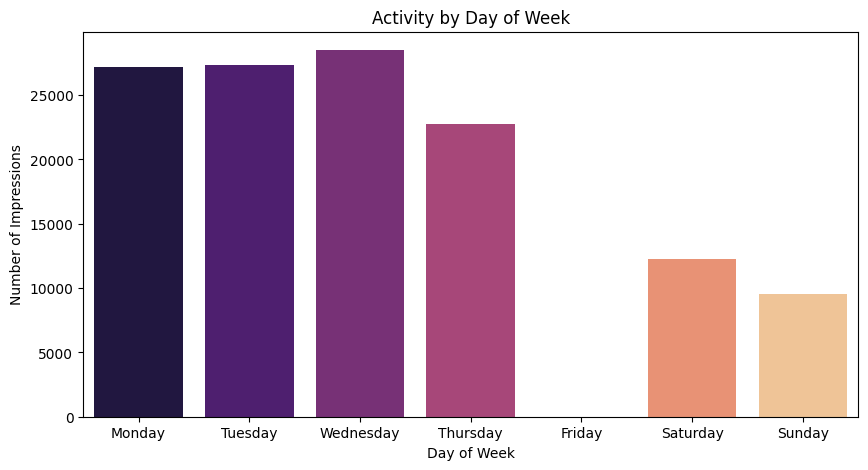

In [15]:
# 3. Activity by day of the week
dow_activity = behaviors.groupby('day_of_week').size()
# Ensure correct order
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_activity = dow_activity.reindex(dow_order)
plt.figure(figsize=(10,5))
sns.barplot(x=dow_activity.index, y=dow_activity.values, palette="magma")
plt.title('Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Impressions')
plt.show()

# TF-IDF model

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
news['content'] = news['title'] + " " + news['abstract']
news = news.reset_index(drop=True)


In [18]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(news['content'])

In [19]:
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [ ]:
def recommend_news(title, news_df, similarity_matrix, top_n=5):
    # Find the index of the given title
    idx = news_df[news_df['title'] == title].index[0]
    
    # Get similarity scores for that article
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity score (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top_n articles (skip the first one because it's the same article)
    top_articles = [i[0] for i in sim_scores[1:top_n+1]]
    
    return news_df.iloc[top_articles][['title', 'abstract']]

In [21]:
np.save("similarity_matrix.npy", similarity_matrix)


# SBERT

In [22]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

/opt/homebrew/Caskroom/miniconda/base/envs/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast

# Generate embeddings (this can take time depending on dataset size)
news_embeddings = model.encode(news['content'], show_progress_bar=True)

news_embeddings = np.array(news_embeddings)
similarity_matrix = cosine_similarity(news_embeddings, news_embeddings)

Batches: 100%|██████████| 148/148 [00:06<00:00, 23.04it/s]


In [27]:
def recommend_news_sbert(title, news_df, similarity_matrix, top_n=5):
    idx = news_df[news_df['title'] == title].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_articles = [i[0] for i in sim_scores[1:top_n+1]]
    return news_df.iloc[top_articles][['title', 'abstract']]

In [29]:
recommend_news_sbert(news.iloc[0]['title'], news, similarity_matrix)

,title,abstract
126,"Top 10 Cheapest New Cars for 2020, and Which A...",You want an inexpensive new car? Try one of these
146,2020 Jeep Gladiator Review: This Jeep Stands O...,Pros and cons on this 2020 Truck of the Year f...
125,Treat Yourself: 16 Cars That Are Worth the Spl...,See some of the best luxury sedans and more en...
97,GM Increases Camaro Discount For Mustang Owner...,"In case you're making a switch, there's a heft..."
127,Toyota Supra 3000GT Concept Has Big Fenders an...,TRD will reveal the full car at SEMA next month.


In [30]:
print(news.iloc[0]['title'])

2020 Hyundai Veloster N Discount Makes It A Better Hot Hatch Deal
